In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde, norm
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from tqdm import tqdm

np.random.seed(0)
font = {'size': 12}
matplotlib.rc('font', **font)

# Quick overview

In [28]:
forward_rate =  pd.read_csv('data/hjm_data.csv').set_index('time') / 100 # Convert interest rates to %
forward_rate

,1/12,1/2,1,1.5,2,2.5,3,3.5,4,4.5,...,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25
time,,,,,,,,,,,,,,,,,,,,,
1,0.057734,0.064382,0.067142,0.066512,0.064991,0.063255,0.061534,0.059925,0.058444,0.057058,...,0.034194,0.034772,0.035371,0.035985,0.036612,0.037252,0.037902,0.038562,0.039231,0.039908
2,0.057680,0.064506,0.067502,0.066842,0.065423,0.063852,0.062301,0.060846,0.059490,0.058198,...,0.033790,0.034437,0.035108,0.035798,0.036504,0.037224,0.037959,0.038705,0.039461,0.040227
3,0.057758,0.064410,0.067354,0.066845,0.065577,0.064109,0.062611,0.061164,0.059782,0.058438,...,0.032706,0.033294,0.033907,0.034539,0.035188,0.035853,0.036533,0.037224,0.037927,0.038639
4,0.057430,0.064103,0.066942,0.066215,0.064904,0.063462,0.062006,0.060601,0.059252,0.057933,...,0.031325,0.031891,0.032486,0.033106,0.033748,0.034409,0.035088,0.035784,0.036493,0.037214
5,0.057412,0.063978,0.066358,0.065502,0.064168,0.062722,0.061262,0.059849,0.058488,0.057157,...,0.030119,0.030667,0.031250,0.031862,0.032499,0.033161,0.033844,0.034546,0.035264,0.035997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,0.046421,0.045093,0.042471,0.042081,0.042663,0.043224,0.043640,0.043940,0.044156,0.044314,...,0.040260,0.040098,0.039950,0.039813,0.039687,0.039571,0.039464,0.039365,0.039273,0.039187
1261,0.046233,0.044976,0.042452,0.042131,0.042726,0.043285,0.043699,0.043998,0.044214,0.044374,...,0.040307,0.040147,0.039999,0.039863,0.039737,0.039621,0.039514,0.039414,0.039320,0.039233
1262,0.046348,0.045311,0.043295,0.043266,0.043963,0.044565,0.045003,0.045323,0.045560,0.045739,...,0.041276,0.041118,0.040972,0.040840,0.040718,0.040607,0.040505,0.040411,0.040324,0.040244


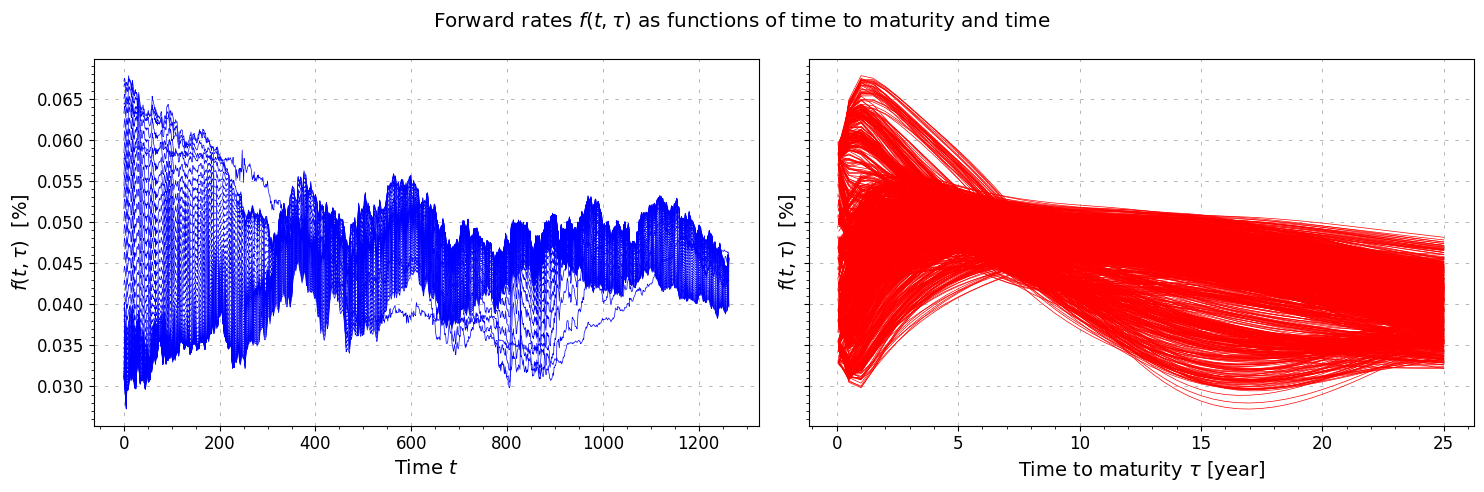

In [29]:
# Extract historical data
hist_timeline = list(forward_rate.index)
tenors = [eval(x) for x in forward_rate.columns]
hist_rates = forward_rate.to_numpy()

def plot_rates(ax, x, y, xlabel, ylabel, color, linewidth, grid_color, title=None):
    ax.plot(x, y, color=color, linewidth=linewidth)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(visible=True, which="major", linestyle="--", dashes=(5, 10),
            color=grid_color, linewidth=0.5, alpha=0.8)
    ax.minorticks_on()
    ax.grid(which="minor", visible=False)
    if title:
        ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
plot_rates(
    ax1, range(len(hist_timeline)), hist_rates,
    xlabel=r'Time $t$', ylabel=r'$f(t,\tau)$  [$\%$]',
    color='blue', linewidth=0.5, grid_color='gray'
)
plot_rates(
    ax2, tenors, hist_rates.transpose(),
    xlabel=r'Time to maturity $\tau$ [year]', ylabel=r'$f(t,\tau)$  [$\%$]',
    color='red', linewidth=0.5, grid_color='gray'
)

fig.suptitle(r'Forward rates $f(t,\tau)$ as functions of time to maturity and time')
plt.tight_layout()
plt.savefig(fname='plots/forward-rates.pdf')
plt.show()

# Differentiate historical rates

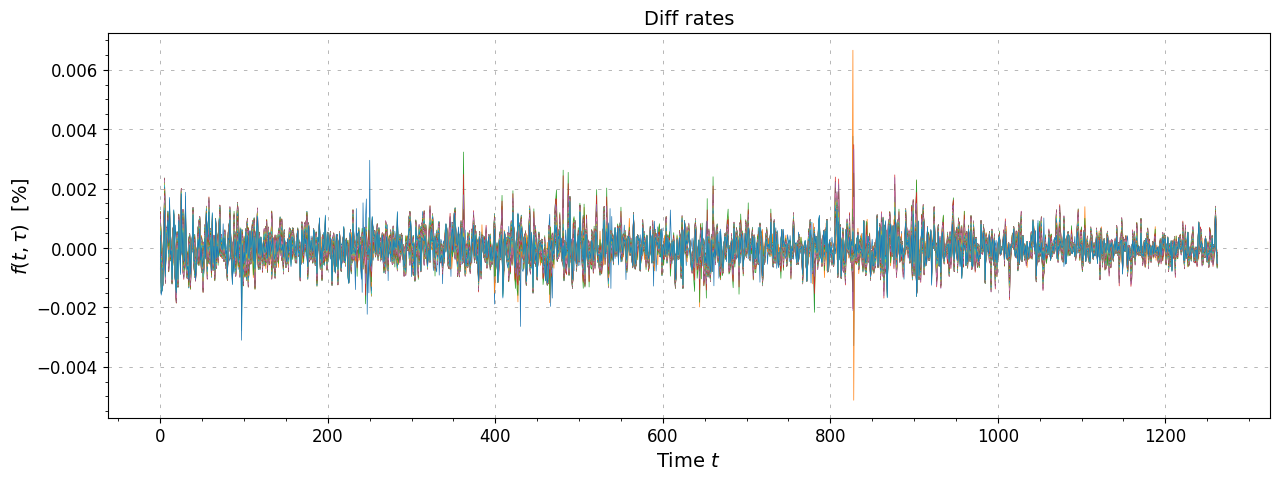

In [30]:
# Calculate differences in forward rates
diff_rates = np.diff(hist_rates, axis=0)

def plot_single_series(x, y, xlabel, ylabel, title, ax=None, linewidth=0.5, grid_color="gray", save_as=None):
    """
    Plot a single series with common formatting.
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))
    ax.plot(x, y, linewidth=linewidth)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(visible=True, which="major", linestyle="--", dashes=(5, 10),
            color=grid_color, linewidth=0.5, alpha=0.8)
    ax.minorticks_on()
    ax.grid(which="minor", visible=False)
    ax.set_title(title, fontsize=14)
    if save_as:
        plt.savefig(fname=save_as)
    plt.show()

plot_single_series(
    x=range(len(diff_rates)), y=diff_rates,
    xlabel=r'Time $t$', ylabel=r'$f(t,\tau)$  [$\%$]',
    title='Diff rates', grid_color='gray', save_as='plots/diff-rates.pdf'
)

# Principal component analysis

Extract principal components from the $df(t,\tau)$

In [31]:
# Calculate covariance matrix
sigma = np.cov(diff_rates.transpose())

Source data are daily rates, therefore annualize covariance matrix (252 financial days). Then compute eigenvalues and eigenvectors

In [32]:
sigma = sigma * 252
eigval, eigvec = np.linalg.eig(sigma)
eigvec = np.matrix(eigvec)
print(eigval)

[2.02884026e-03 4.62889282e-04 1.63677691e-04 8.47948767e-05
 5.10134525e-05 3.26491422e-05 1.53862297e-05 3.90765854e-06
 1.45385608e-06 3.99451236e-07 7.74123147e-08 2.25094244e-08
 6.81015644e-09 2.04941493e-09 8.30654947e-10 3.18422245e-10
 1.69855176e-10 1.20686709e-10 8.18818675e-11 4.65678731e-11
 2.41691330e-11 1.26818337e-11 7.83625735e-12 4.07031445e-12
 2.61695757e-12 1.78999756e-12 1.07235511e-12 6.26514631e-13
 3.36669763e-13 2.89485592e-13 2.09893594e-13 2.02355379e-13
 1.20792326e-13 9.80002681e-14 7.30539108e-14 5.84913877e-14
 5.01860718e-14 4.50412066e-14 4.25136155e-14 3.00503786e-14
 1.99691814e-14 1.44931169e-14 8.67085372e-15 6.67525091e-15
 5.37129004e-15 4.23435563e-15 2.52344995e-15 1.26741475e-15
 4.34926875e-17 1.87394604e-16 2.51628579e-16]


Determine principal components, Select eigen vectors with highest eigenvalues. Link between tenors and eigenvectors is not guaranteed.

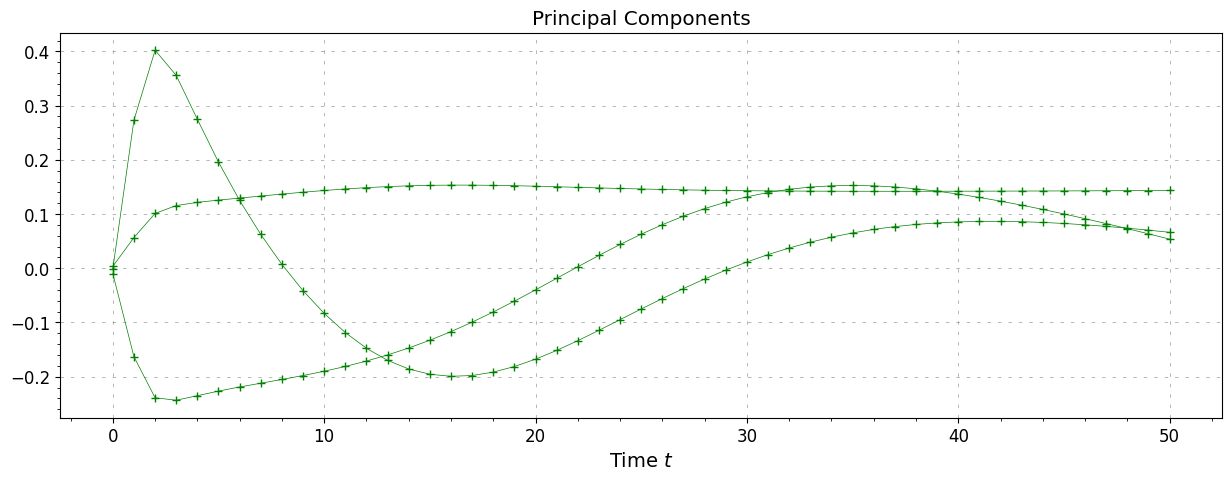

In [33]:
factors = 3

top_eigen_indices = np.argsort(eigval)[::-1][:factors]  # Indices of the principal eigenvectors
principal_eigenvalues = eigval[top_eigen_indices]
principal_components = eigvec[:, top_eigen_indices]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(principal_components, marker='+', color='green', linewidth=0.5)
ax.set_xlabel(r'Time $t$', fontsize=14)
ax.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5, alpha=0.8)
ax.minorticks_on()
ax.grid(which="minor", visible=False)
plt.title("Principal Components")

plt.savefig(fname='plots/principal_components.pdf')
plt.show()

Calculate discretized volatility function from principal components

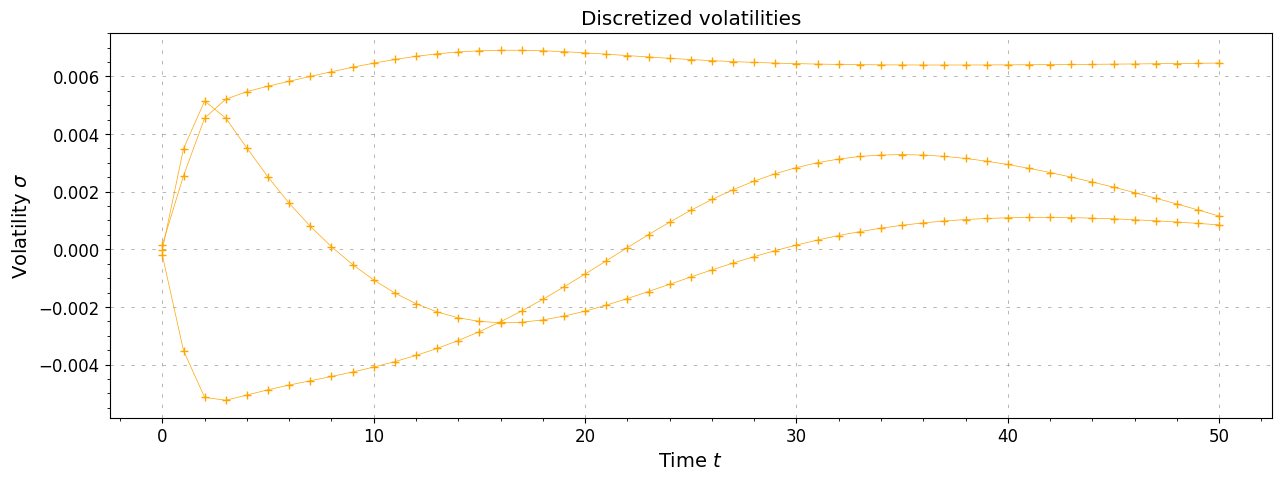

In [34]:
sqrt_eigval = np.matrix(principal_eigenvalues ** .5)
tmp_m = np.vstack([sqrt_eigval for i in range(principal_components.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols = np.multiply(tmp_m, principal_components) # multiply matrice element-wise

fig, ax = plt.subplots(1, figsize=(15,5),)

ax.plot(vols, marker='+', color='orange', linewidth=0.5)
ax.set_ylabel(r'Volatility $\sigma$', fontsize=14)
ax.set_xlabel(r'Time $t$', fontsize=14)
ax.grid(visible=True,which="major",linestyle="--",dashes=(5, 10),color="gray",linewidth=0.5,alpha=0.8)
ax.minorticks_on()
ax.grid(which="minor", visible=False)
plt.title("Discretized volatilities")

plt.savefig(fname='plots/discretized-volatilities.pdf')
plt.show()

# Volatility Fitting

We need to fit discretized volatility functions from the previous step using cubic interpolators. The reason is that these interpolators will be later integrated numerically in order to calculate risk-neutral drift. Fitting is done using cubic spline

In [35]:
def get_matrix_column(mat, i):
    return np.array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params:np.ndarray):
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = np.array([x**i for i in reversed(range(n))])
        return sum(np.multiply(X, C))

We will approximate the first principal component with interpolator with 0 degree (straight line). This approximates well parallel movements of interest rates.

In [36]:
fitted_vols = []

2nd and 3rd principal component will be approximated using cubic interpolator with degree 3.

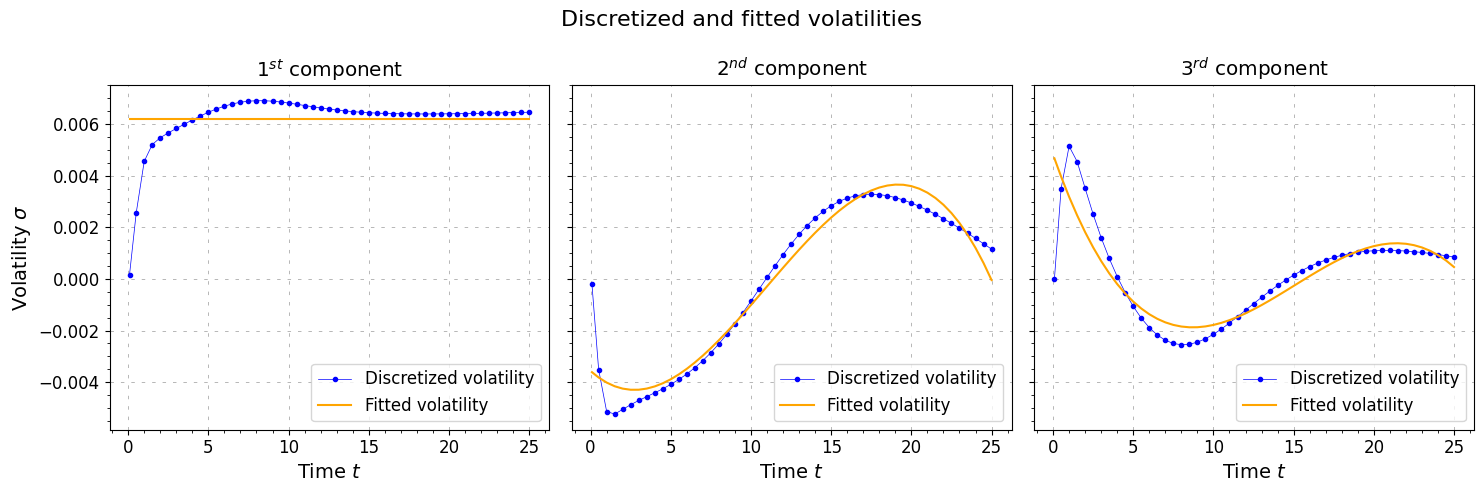

In [37]:
def fit_volatility(i, degree, title, ax):
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(np.polyfit(tenors, vol, degree))
    fitted_vols.append(fitted_vol)

    ax.plot(tenors, vol, marker='.', label='Discretized volatility', color='blue', linewidth=0.5)
    ax.plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility', color='orange')

    ax.set_title(title)
    ax.grid(which="minor", visible=False)
    ax.grid(visible=True,which="major",linestyle="--",dashes=(5, 10),color="gray",linewidth=0.5,alpha=0.8)
    ax.minorticks_on()
    ax.set_xlabel(r'Time $t$', fontsize=14)
    ax.legend(loc='lower right')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), sharey=True)
plt.title("Discretized and fitted volatilities")
ax1.set_ylabel(r'Volatility $\sigma$', fontsize=14)
fit_volatility(0, 0, r'$1^{st}$ component', ax1)
fit_volatility(1, 3, r'$2^{nd}$ component', ax2)
fit_volatility(2, 3, r'$3^{rd}$ component', ax3)

fig.suptitle(r'Discretized and fitted volatilities', fontsize=16)
plt.tight_layout()
plt.savefig(fname='plots/discretized-and-fitted-volatilities.pdf')
plt.show()

# Monte Carlo Simulation

In [38]:
# === Parameters of the simulation ===
n_simulations = 10000  # Number of Monte Carlo trajectories
time_steps = 250      # Number of timestamps (One Market Year)
dt = 1 / 252          # Time Interval (One day)
horizon = time_steps * dt  # Total duration
tenors = np.array(tenors)  # Maturities

# === Initialization of volatilities and rates ===
initial_rates = hist_rates[-1]  # Last observed rate as starting point

In [39]:
# Volatilities interpolation
interpolators = [interp1d(tenors, get_matrix_column(vols, i), kind='cubic', fill_value="extrapolate")
                 for i in range(vols.shape[1])]

# Generation of an interpolated volatilities matrix for each time and maturity
def interpolate_volatility(time_steps, tenors, interpolators):
    interpolated_vols = np.zeros((time_steps, len(tenors)))
    for i, interp in enumerate(interpolators):
        interpolated_vols[:, i] = interp(np.linspace(tenors.min(), tenors.max(), time_steps))
    return interpolated_vols

vol_matrix = interpolate_volatility(time_steps, tenors, interpolators)

In [40]:
# Compute drift
def compute_integral(vol_matrix, t, T, dt):
    integral = np.zeros(len(tenors))
    for i in range(len(tenors)):
        integral[i] = np.sum(vol_matrix[t:T, i]) * dt  # Discrétisation de l'intégrale
    return integral

100%|██████████| 10000/10000 [05:05<00:00, 32.69it/s]


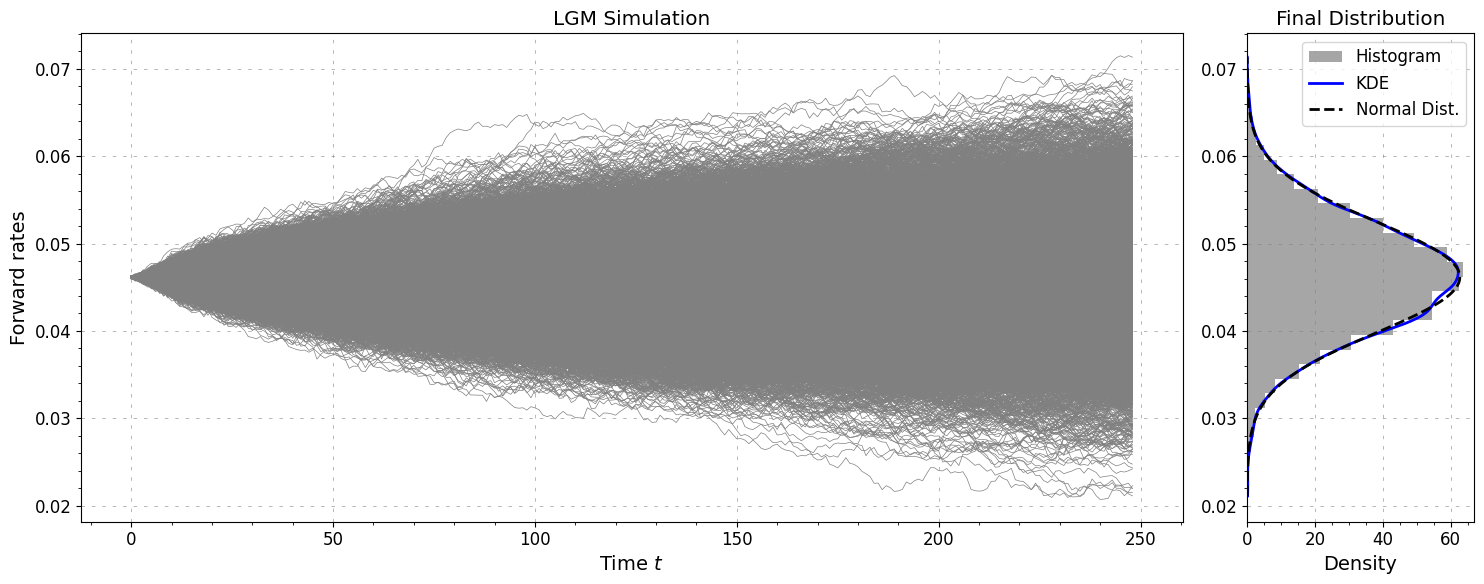

In [41]:
# === LGM Model with Drift ===
lgm_trajectories = np.zeros((n_simulations, time_steps, len(tenors)))
drift_list= []

for sim in tqdm(range(n_simulations)):
    rates = initial_rates.copy()

    for t in range(1, time_steps):

        # Calculate the drift (using the formula for α(t,T))
        drift = np.zeros(len(tenors))  # Initialize drift for all tenors
        for i in range(3):  # 3 factors for drift
            # Calculate the integral part of the drift
            integral = np.sum(vol_matrix[:t, i]) * dt  # Integral from time 0 to t
            drift += vol_matrix[t, i] * integral
            drift_list.append(drift)

        # Add the drift to the evolution of the rates
        shocks = np.random.normal(0, 1, size=len(tenors))
        drates = drift * dt + vol_matrix[t] * shocks * np.sqrt(dt)
        rates += drates
        lgm_trajectories[sim, t] = rates

# === LGM trajectories visualization with final distribution ===
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 5, figure=fig)

# Main plot for the simulated trajectories
ax_lines = fig.add_subplot(gs[:, :-1])
for sim in range(n_simulations):
    ax_lines.plot(lgm_trajectories[sim, 1:, 0], linewidth=0.5, color='gray')  # Trajectories for a specific tenor
ax_lines.set_title('LGM Simulation')
ax_lines.set_xlabel(r'Time $t$', fontsize=14)
ax_lines.set_ylabel('Forward rates', fontsize=14)
ax_lines.grid(which="minor", visible=False)
ax_lines.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5, alpha=0.8)
ax_lines.minorticks_on()

# Right histogram for the final forward rates
final_rates = lgm_trajectories[:, -1, 0]  # Extract final rates for the specific tenor
ax_hist = fig.add_subplot(gs[:, -1], sharey=ax_lines)
ax_hist.hist(final_rates, bins=30, orientation='horizontal', color='gray', alpha=0.7, density=True, label="Histogram")

# KDE for the final rates
kde = gaussian_kde(final_rates)
y_vals = np.linspace(final_rates.min(), final_rates.max(), 500)
ax_hist.plot(kde(y_vals), y_vals, color='blue', linewidth=2, label="KDE")

# Normal distribution curve
mean, std = final_rates.mean(), final_rates.std()
normal_pdf = norm.pdf(y_vals, loc=mean, scale=std)
ax_hist.plot(normal_pdf, y_vals, color='black', linestyle='--', linewidth=2, label="Normal Dist.")

# Formatting the right plot
ax_hist.set_title('Final Distribution')
ax_hist.set_xlabel('Density', fontsize=14)
ax_hist.yaxis.set_visible(True)
ax_hist.grid(which="minor", visible=False)
ax_hist.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5, alpha=0.8)
ax_hist.minorticks_on()
ax_hist.legend()

plt.tight_layout()
plt.savefig(fname='plots/lgm_simulation_with_histogram_and_kde.pdf')
plt.show()


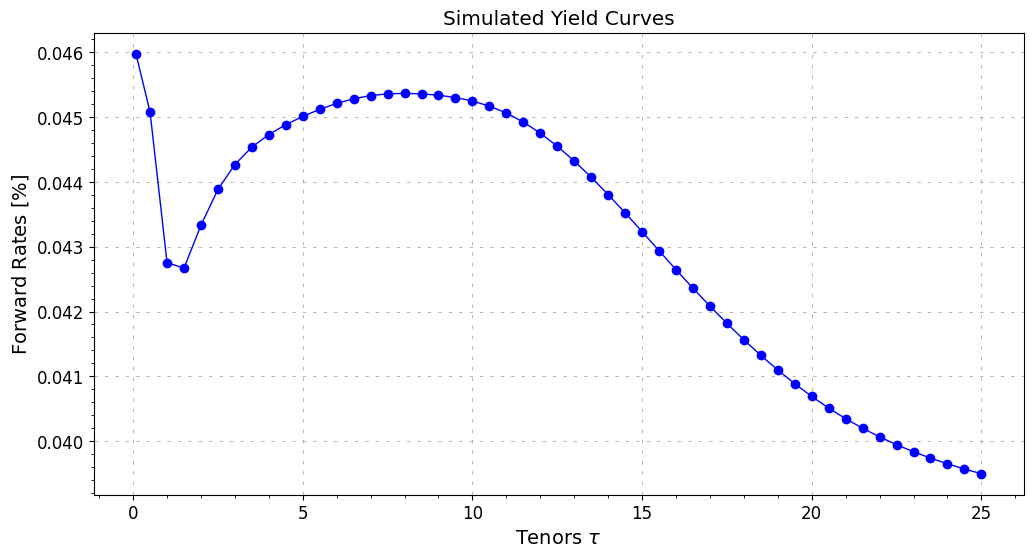

In [42]:
# === Yield Curves Visualization (All Simulations + Mean) ===
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# # Sélection d'instants temporels pour les yield curves
# time_indices = [time_steps // 4, time_steps // 2, 3 * time_steps // 4, time_steps - 1]  # Début, quarts, fin
# colors=['blue', 'green', 'orange', 'red']

# # Courbes moyennes avec des couleurs pour chaque instant
# for idx, t in enumerate(time_indices):
#     mean_yield_curve = lgm_trajectories[:, t, :].mean(axis=0)  # Moyenne des taux sur les simulations pour chaque tenor
#     ax.plot(tenors, mean_yield_curve, marker='o', color=colors[idx], linewidth=2, label=f'{round(t/252*100)}')

ax.plot(tenors, lgm_trajectories.mean(axis=0).mean(axis=0), color='blue', marker='o', linewidth=1)

# Formatage
ax.set_title('Simulated Yield Curves')
ax.set_xlabel(r'Tenors $\tau$', fontsize=14)
ax.set_ylabel(r'Forward Rates [$\%$]', fontsize=14)
ax.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5, alpha=0.8)
ax.minorticks_on()
# ax.legend(title=r'Time [$\%$ of the year]')
plt.savefig(fname='plots/yield_curves_simulated.pdf')
plt.show()